Calculate view factors
==================

In this section, we will learn how to:

- calculate the view factor matrix from a PV array object
- plot the pvarray with indices to visualize the meaning of the matrix

Note: the following calculation steps are already implemented in the simulation engine ``PVEngine``, please refer to the following tutorials for running complete simulations.

Imports and settings

In [1]:
# Import external libraries
import matplotlib.pyplot as plt
import numpy as np

# Settings
%matplotlib inline
np.set_printoptions(precision=3)

### Prepare PV array parameters

In [2]:
pvarray_parameters = {
    'n_pvrows': 2,            # number of pv rows
    'pvrow_height': 1,        # height of pvrows (measured at center / torque tube)
    'pvrow_width': 1,         # width of pvrows
    'axis_azimuth': 0.,       # azimuth angle of rotation axis
    'surface_tilt': 20.,      # tilt of the pv rows
    'surface_azimuth': 90.,   # azimuth of the pv rows front surface
    'solar_zenith': 40.,      # solar zenith angle
    'solar_azimuth': 150.,    # solar azimuth angle
    'gcr': 0.5,               # ground coverage ratio
}

### Create a PV array and required attributes

Import the ``OrderedPVArray`` class and create a PV array object using the parameters above

In [3]:
from pvfactors.geometry import OrderedPVArray

pvarray = OrderedPVArray.transform_from_dict_of_scalars(pvarray_parameters)

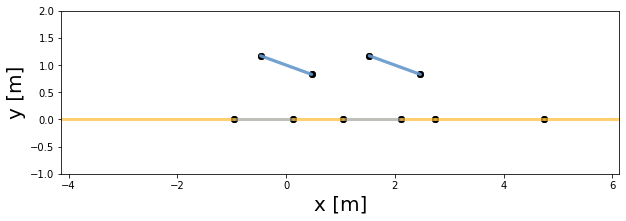

In [4]:
# Plot pvarray shapely geometries
f, ax = plt.subplots(figsize=(10, 3))
pvarray.plot(ax)
plt.show()

As discussed in the "PV Array geometry introduction" tutorial, the ground also has "cut points" to indicate the limits of what the PV row front and back sides can see.

### Intermediate steps: getting the view matrix

In order to calculate the view factor matrix, we need to obtain a number of properties from the PV array object:

- a dictionary where the keys are the surface indices, and values the surfaces themselves
- the view matrix of the PV array
- the obstruction matrix of the PV array
- the list of pvrows in the PV array

In [5]:
# Get geometry dictionary
geom_dict = pvarray.dict_surfaces
# Get view and obstruction matrices
view_matrix = pvarray.view_matrix
obstr_matrix = pvarray.obstr_matrix
# Get list of pvrows
list_pvrows = pvarray.pvrows

The view and obstruction matrices are intermediate steps to calculate the final view factor matrix.

- the view matrix defines the type of view between any surface of the PV array to any other surface
- the obstruction matrix flags the index of a potentially obstructing PV row

In [6]:
print(view_matrix)

[[ 0  0  0  0  0  0  0  0  7  0  7  1]
 [ 0  0  0  0  0  0  0  0  7  0  7  1]
 [ 0  0  0  0  0  0  0  0  7  0  7  1]
 [ 0  0  0  0  0  0  0  9  0  0  7  1]
 [ 0  0  0  0  0  0  0  9  0  9  0  1]
 [ 0  0  0  0  0  0  0  0  7  0  7  1]
 [ 0  0  0  0  0  0  0  0  7  0  7  1]
 [ 0  0  0  8  8  0  0  0  0  0 10  4]
 [ 6  6  6  0  0  6  6  0  0  0  0  5]
 [ 0  0  0  0  8  0  0  0  0  0  0  4]
 [ 6  6  6  6  0  6  6 10  0  0  0  5]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]


In [7]:
print(obstr_matrix)

[[None None None None None None None None None None 0 None]
 [None None None None None None None None None None 0 None]
 [None None None None None None None None None None 0 None]
 [None None None None None None None 1 None None 0 None]
 [None None None None None None None 1 None None None None]
 [None None None None None None None None None None 0 None]
 [None None None None None None None None None None 0 None]
 [None None None 1 1 None None None None None None None]
 [None None None None None None None None None None None None]
 [None None None None None None None None None None None None]
 [0 0 0 0 None 0 0 None None None None None]
 [None None None None None None None None None None None None]]


Now we have all we need to calculate the view factors.

### Calculating the view factor matrix

View factors will be calculated using a view factor calculator, applied to the PV array object.

In [8]:
# import view factor calculator
from pvfactors.viewfactors import VFCalculator
# instantiate calculator
vf_calculator = VFCalculator()

In [9]:
# calculate view factor matrix of the pv array
vf_matrix = vf_calculator.get_vf_matrix(geom_dict, view_matrix, obstr_matrix, list_pvrows)

It is important to note that the view factor matrix has an additional row and column compared to the view matrix, because it calculates the view factors to the sky as well.

In [10]:
print(vf_matrix)

[[0.    0.    0.    0.    0.    0.    0.    0.    0.003 0.    0.001 0.997]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.268 0.    0.15  0.582]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.003 0.    0.321 0.675]
 [0.    0.    0.    0.    0.    0.    0.    0.003 0.    0.    0.046 0.951]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.368 0.    0.055 0.577]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.042 0.    0.368 0.59 ]
 [0.    0.    0.    0.005 0.015 0.    0.    0.    0.    0.    0.037 0.943]
 [0.276 0.246 0.002 0.    0.    0.398 0.046 0.    0.    0.    0.    0.032]
 [0.    0.    0.    0.    0.028 0.    0.    0.    0.    0.    0.    0.972]
 [0.054 0.137 0.201 0.093 0.    0.059 0.398 0.037 0.    0.    0.    0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]]


Here is a function to help make sense of this

In [11]:
def select_view_factor(i, j, vf_matrix):
    "Function to print the view factors"
    n = vf_matrix.shape[0] - 1
    vf = vf_matrix[i, j]
    # print the view factor
    i = i if i < n else 'sky'
    j = j if j < n else 'sky'
    print('View factor from surface {} to surface {}: {}'.format(i, j, np.around(vf, decimals=2)))

In [12]:
# View factors from back of leftmost pv row
select_view_factor(8, 5, vf_matrix)
select_view_factor(8, 6, vf_matrix)
select_view_factor(8, 3, vf_matrix)
# View factors from back of rightmost pv row
select_view_factor(10, 6, vf_matrix)
# View factors from front of leftmost pv row
select_view_factor(7, 11, vf_matrix)
# View factors from front of rightmost pv row
select_view_factor(9, 11, vf_matrix)

View factor from surface 8 to surface 5: 0.4
View factor from surface 8 to surface 6: 0.05
View factor from surface 8 to surface 3: 0.0
View factor from surface 10 to surface 6: 0.4
View factor from surface 7 to surface sky: 0.94
View factor from surface 9 to surface sky: 0.97


Let's plot the PV array with the surface indices to understand visually what these numbers mean:

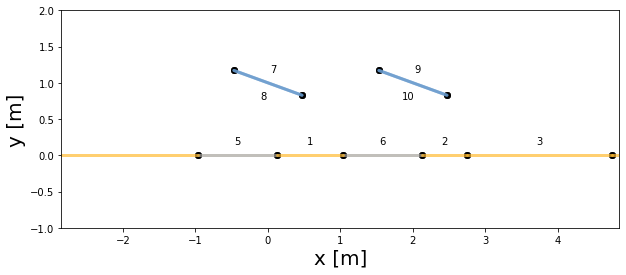

In [13]:
# Plot pvarray shapely geometries
f, ax = plt.subplots(figsize=(10, 4))
pvarray.plot(ax, with_index=True)
plt.show()

Note that the indices of the leftmost and rightmost ground surfaces are not shown in the plot above (respectively 0 and 4).